本文中，我们将使用*Python*模块[gensim](http://radimrehurek.com/gensim/models/word2vec.html#id6)对文本训练，生成词向量（即将每个词用向量表示）。使用的数据集为Mikolov所使用的[text8](http://mattmahoney.net/dc/text8.zip)，训练模型为*skip-gram*, *CBOW*。如果你对词向量的概念不甚熟悉，可以拜读下皮果提的[CSDN博客](http://blog.csdn.net/itplus/article/details/37969519)，他深入浅出的介绍了一些列的背景知识、相关概念以及理论推导。

In [1]:
from collections import Counter
from gensim.models import word2vec 
#from glove import Glove 
#from glove import Corpus 
import argparse
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


首先，我们读取本地的*text8*数据，关于*gensim*里面的词向量建模工具*word2vec*，可以参看官方文档。

# Fetch 20Newsgroup Data

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', 
                                  shuffle=True, random_state=11)
newsgroups_test = fetch_20newsgroups(subset='test', 
                                  shuffle=True, random_state=11)

In [3]:
print("\n".join(newsgroups_train.data[0].split("\n")))

From: EEI.EEIIHY@memo.ericsson.SE (353-1-2800455)
Subject: help
Organization: The Internet
Lines: 5
NNTP-Posting-Host: enterpoop.mit.edu
To: XPERT@EXPO.LCS.MIT.EDU

--- Received from EEI.EEIIHY  353-1-2800455         93-04-26 12.28
  -> VAX.XPERT..EXPO.LCS.MIT.EDU..INET
  -: - - - - - - - - - - > MAIL USER IN VAX AND INTERNET
help




In [4]:
#数据预处理
import string
import re
def preProcessor(s):
    #s = s.encode('utf-8')
    s = re.sub('['+string.punctuation+']', ' ', s)
    s = re.sub('['+string.digits+']', ' ', s)
    s = re.sub('\n', ' ', s)
    s = s.lower()
    #s = s.translate(string.punctuation)
    return s

In [5]:
preProcessor(newsgroups_train.data[0])

'from  eei eeiihy memo ericsson se                 subject  help organization  the internet lines    nntp posting host  enterpoop mit edu to  xpert expo lcs mit edu      received from eei eeiihy                                            vax xpert  expo lcs mit edu  inet                            mail user in vax and internet help  '

In [6]:
from sklearn.feature_extraction.text import  TfidfVectorizer
#Obtain tf-idf vector for each article
#remove stopwords in Enlgish
tfidfVectorizer = TfidfVectorizer(stop_words='english', min_df=5, preprocessor=preProcessor, ngram_range=(1, 2))
X_train_tfidf = tfidfVectorizer.fit_transform(newsgroups_train.data)
X_train_tfidf.shape

(11314, 59526)

In [7]:
X_test_tfidf = tfidfVectorizer.transform(newsgroups_test.data)

In [8]:
news_words = tfidfVectorizer.get_feature_names()
len(news_words)

59526

In [9]:
news_words[:20]

['aa',
 'aa freenet',
 'aa inet',
 'aa insane',
 'aa mon',
 'aa organization',
 'aaa',
 'aaa uoregon',
 'aamir',
 'aamir hafeez',
 'aamir qazi',
 'aardvark',
 'aardvark ucs',
 'aargh',
 'aargh great',
 'aario',
 'aario measure',
 'aario sami',
 'aaron',
 'aaron arc']

## Doc2Vec模型

Doc2vec的原理和实现可以参考Tomas Mikolov的文章：http://cs.stanford.edu/~quocle/paragraph_vector.pdf 。

In [10]:
from gensim.utils import simple_preprocess 
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
#清除数字和换行符，将标点符号当作词
def cleanText(corpus):
    for c in string.punctuation:  
        corpus = [z.lower().replace(c,' %s '%c ) for z in corpus]
    corpus = [re.sub('['+string.punctuation+']', '', s) for s in corpus]
    corpus = [re.sub('['+string.digits+']', '', z) for z in corpus]
    corpus = [z.lower().replace('\n','').split() for z in corpus]   
    #corpus = [simple_preprocess(z) for z in corpus]
    return corpus
train_corpus = cleanText(newsgroups_train.data)   
test_corpus = cleanText(newsgroups_test.data)   

In [35]:
from gensim.models import doc2vec
labeledSentence = doc2vec.LabeledSentence
#给每篇新闻加上标签
def labelizeNews(news, label_type):
    labelized = []
    for i, v in enumerate(news):
        label = '%s_%s'%(label_type, i)
        labelized.append(labeledSentence(v, [label]))
    return labelized
all_corpus_tagged = np.concatenate((train_corpus, test_corpus))
all_corpus_tagged = labelizeNews(all_corpus_tagged, 'document')
train_corpus_tagged = all_corpus_tagged[:len(train_corpus)]
test_corpus_tagged = all_corpus_tagged[len(train_corpus):]

In [36]:
#采用dbow和dm两种模型进行训练
size = 100
alpha = 0.004
min_alpha = 0.004
#文档向量训练
news_d2v_dbow = doc2vec.Doc2Vec(min_count=2, window=5, size=size, 
                              dm=1, sample=1e-3, negative=5, workers=3, alpha=alpha, min_alpha=alpha)
news_d2v_dm = doc2vec.Doc2Vec(min_count=2, window=5, size=size, hs=0, sample=1e-3, 
                              dm=0, negative=5, workers=3, alpha=alpha, min_alpha=min_alpha)
news_d2v_dm.build_vocab(train_corpus_tagged)
news_d2v_dbow.build_vocab(train_corpus_tagged)

In [37]:
#对文档向量进行训练
#多次进行训练
import random
num_step = 30
interval = 0.0001
for _ in range(num_step):
    #Shuffle the data set
    #random.shuffle(train_corpus_tagged)
    news_d2v_dm.train(train_corpus_tagged, total_examples=news_d2v_dm.corpus_count,
                      epochs=5)
    news_d2v_dm.alpha -= interval
    news_d2v_dm.min_alpha = news_d2v_dm.alpha
    
    news_d2v_dbow.train(train_corpus_tagged, total_examples=news_d2v_dm.corpus_count,
                      epochs=5)
    news_d2v_dbow.alpha -= interval
    news_d2v_dbow.min_alpha = news_d2v_dbow.alpha

In [ ]:
#对文档向量进行训练
#多次进行训练
import random
num_step = 20
interval = 0.0001
for _ in range(num_step):
    #Shuffle the data set
    random.shuffle(train_corpus_tagged)
    news_d2v_dm.train(train_corpus_tagged, total_examples=news_d2v_dm.corpus_count,
                      epochs=5)
    news_d2v_dm.alpha -= interval
    news_d2v_dm.min_alpha = news_d2v_dm.alpha
    
    news_d2v_dbow.train(train_corpus_tagged, total_examples=news_d2v_dm.corpus_count,
                      epochs=5)
    news_d2v_dbow.alpha -= interval
    news_d2v_dbow.min_alpha = news_d2v_dbow.alpha

In [26]:
#第一篇新闻的向量
len(news_d2v_dm.docvecs)

11314

In [38]:
#生成测试数据文档向量
def inferVecs(model, test_corpus, size):
    '''Infer the vector of a given sentence'''
    vecs = []
    for t in test_corpus:
        #z = simple_preprocess(t)
        vec = model.infer_vector(t).reshape((1, size))
        vecs.append(vec)
    return np.concatenate(vecs)

In [39]:
#获取每篇新闻的向量
dm_doc_vecs = np.concatenate([vec.reshape(1, size) for vec in news_d2v_dm.docvecs])
dbow_doc_vecs = np.concatenate([vec.reshape(1, size) for vec in news_d2v_dbow.docvecs])
train_doc_vecs = np.hstack((dm_doc_vecs, dbow_doc_vecs))
dm_doc_vecs = inferVecs(news_d2v_dm, test_corpus, size)
dbow_doc_vecs = inferVecs(news_d2v_dbow, test_corpus, size)
test_doc_vecs = np.hstack((dm_doc_vecs, dbow_doc_vecs))

In [40]:
##逻辑回归分类
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(C=0.05, random_state=111, n_jobs=4)
lr_model.fit(train_doc_vecs, newsgroups_train.target)
predicted = lr_model.predict(test_doc_vecs)
print('Accuracy of Logistic Regression: {:.3f}'.format(np.mean(predicted == newsgroups_test.target)))

Accuracy of Logistic Regression: 0.767


In [41]:
#支持适量机分类
from sklearn.svm import SVC
svc_model = SVC(C=0.8, random_state=111)
svc_model.fit(train_doc_vecs, newsgroups_train.target)
predicted = svc_model.predict(test_doc_vecs)
print('Accuracy of SVC: {:.3f}'.format(np.mean(predicted == newsgroups_test.target)))

Accuracy of SVC: 0.729


In [31]:
#多层感知器分类
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(128,), activation='relu', solver='sgd', alpha=0.0002,
                    learning_rate_init=0.001, random_state=111, verbose=True, tol=0.00001, max_iter=5000)

In [32]:
mlp.fit(train_doc_vecs, newsgroups_train.target)

Iteration 1, loss = 3.10654200
Iteration 2, loss = 2.98203873
Iteration 3, loss = 2.88545371
Iteration 4, loss = 2.79972434
Iteration 5, loss = 2.71676904
Iteration 6, loss = 2.63360483
Iteration 7, loss = 2.54892961
Iteration 8, loss = 2.46191365
Iteration 9, loss = 2.37244984
Iteration 10, loss = 2.28093605
Iteration 11, loss = 2.18790650
Iteration 12, loss = 2.09394552
Iteration 13, loss = 2.00060961
Iteration 14, loss = 1.90897055
Iteration 15, loss = 1.81968640
Iteration 16, loss = 1.73393174
Iteration 17, loss = 1.65244188
Iteration 18, loss = 1.57571342
Iteration 19, loss = 1.50411857
Iteration 20, loss = 1.43765843
Iteration 21, loss = 1.37616950
Iteration 22, loss = 1.31972094
Iteration 23, loss = 1.26787070
Iteration 24, loss = 1.22026703
Iteration 25, loss = 1.17656875
Iteration 26, loss = 1.13652979
Iteration 27, loss = 1.09984595
Iteration 28, loss = 1.06604326
Iteration 29, loss = 1.03485658
Iteration 30, loss = 1.00604185
Iteration 31, loss = 0.97937465
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0002, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(128,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=111,
       shuffle=True, solver='sgd', tol=1e-05, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [33]:
predicted = mlp.predict(test_doc_vecs)
print('Accuracy of SVC: {:.3f}'.format(np.mean(predicted == newsgroups_test.target)))

Accuracy of SVC: 0.741


## 文档可视化

选择一部分文档向量进行降维可视化。

In [42]:
doc_vecs = train_doc_vecs[:500]

In [43]:
#将词向量降维为2维向量
model_TSNE = TSNE(n_components=2, random_state=0)
doc_vec_2D = model_TSNE.fit_transform(doc_vecs)
doc_labels = newsgroups_train.target[:500]

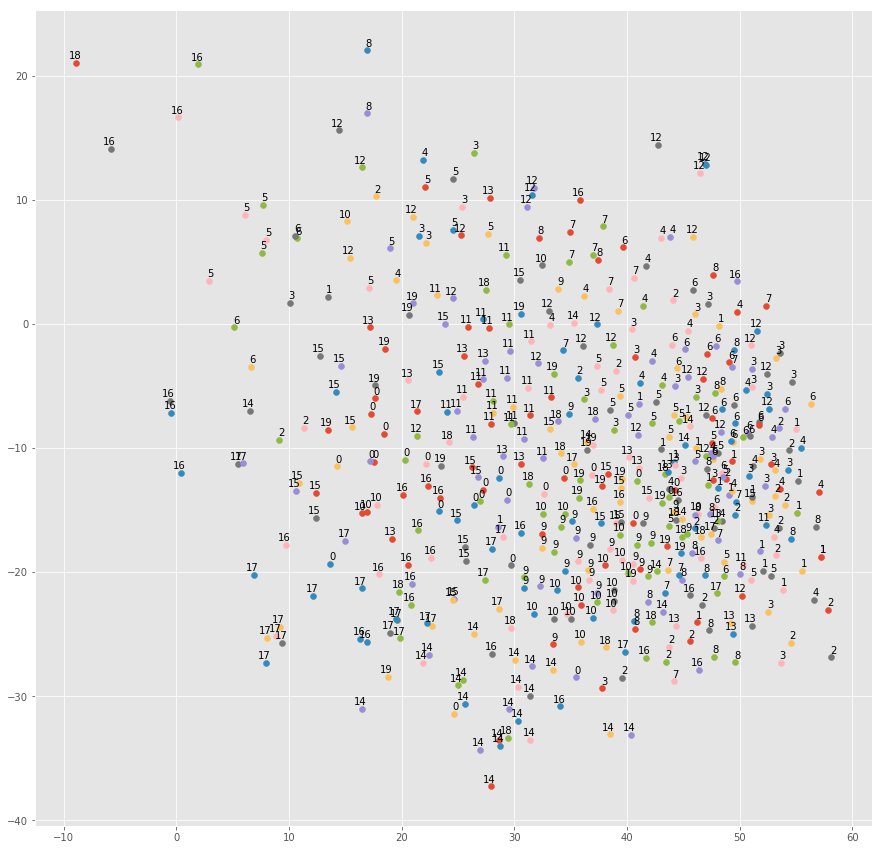

In [44]:

plt.style.use('ggplot')#设置ggplot风格的背景
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    #显示散点图并进行标注
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  plt.show()
plot(doc_vec_2D, doc_labels)